In [1]:
import os
import sys
import glob
import math
import itertools
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path
sys.path.append(str(Path("..").resolve()))
from data_handling import load_state_npz

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dir = Path("models")
state_dir = Path("state_vectors")

print(f"Running on: {device}")
print(f"Looking for models in: {models_dir.resolve()}")

Running on: cpu
Looking for models in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4_tests/models


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        fe_v = term1_v - term2_v
        fe_flipped = term1_f - term2_f

        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator, burn_in: int = 50):
        cond = cond.to(device)
        if cond.dim() == 1: cond = cond.expand(n_samples, -1)
        b_mod, c_mod = self._compute_effective_biases(cond)

        probs = torch.full((n_samples, self.num_visible), 0.5, device=device)
        v = torch.bernoulli(probs, generator=rng)

        for _ in range(burn_in):
            v = self._gibbs_step(v, b_mod, c_mod, rng)
        return v

In [3]:
def load_latest_model():
    # Use glob to find files, then convert to Path objects
    pt_files = sorted(glob.glob(str(models_dir / "*.pt")), key=os.path.getmtime, reverse=True)
    if not pt_files:
        raise FileNotFoundError("No .pt files found in models directory.")

    latest_path = Path(pt_files[0])
    print(f"Loading checkpoint: {latest_path.name}")

    checkpoint = torch.load(latest_path, map_location=device)
    config = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=config["num_visible"],
        num_hidden=config["num_hidden"],
        cond_dim=1,
        k=config.get("k_steps", 1),
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    return model, config

model, config = load_latest_model()
GEN_SIDE_LENGTH = int(math.sqrt(model.num_visible))
h_support = config.get("h_support", [])

print(f"Model Loaded. System Size: {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}")
print(f"Trained on Support: {h_support}")

Loading checkpoint: crbm_tfim_4x4_50000_20251210_223015.pt
Model Loaded. System Size: 4x4
Trained on Support: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


In [4]:
@torch.no_grad()
def estimate_fidelity_mc(model, h_val, n_samples=20000):
    """
    Estimates Fidelity using Two-Way Monte Carlo (Quotient Method).
    """
    # 0. Datatype Safety
    model_dtype = next(model.parameters()).dtype

    # 1. Load Exact State (Ground Truth)
    state_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
    if not state_path.exists():
        return None

    psi_np, _ = load_state_npz(state_path)
    # Explicit cast to model_dtype to ensure compatibility
    psi_exact_vec = torch.from_numpy(psi_np).real.to(dtype=model_dtype, device=device)
    psi_exact_vec = psi_exact_vec / torch.norm(psi_exact_vec)

    # Pre-compute powers of 2 for bitstring <-> index conversion
    # shape: [1, 2, 4, 8...]
    powers = 2 ** torch.arange(GEN_SIDE_LENGTH**2 - 1, -1, -1, device=device)

    # ---------------------------------------------------------
    # PART A: Forward Sampling (RBM -> Exact)
    # Estimator E1 = < Psi_E / Psi_M >_{sampled from M}
    # ---------------------------------------------------------
    rng = torch.Generator(device=device).manual_seed(42)

    # FIX: Explicit dtype for condition
    cond = torch.tensor([[h_val]], device=device, dtype=model_dtype)
    cond_batch = cond.expand(n_samples, -1)

    # Sample from RBM
    samples_rbm = model.generate(cond, n_samples, rng, burn_in=100)

    # Get RBM Log Amplitudes
    log_psi_rbm = model.log_score(samples_rbm, cond_batch)

    # Get Exact Amplitudes (via index lookup)
    indices_rbm = (samples_rbm * powers).sum(dim=1).long()
    psi_exact_vals = psi_exact_vec[indices_rbm]

    # Ratio 1: |Psi_E| / exp(log_psi_M)
    # Using abs() because we care about overlap magnitude
    ratio_1 = torch.abs(psi_exact_vals) / torch.exp(log_psi_rbm)
    E1 = ratio_1.mean()

    # ---------------------------------------------------------
    # PART B: Reverse Sampling (Exact -> RBM)
    # Estimator E2 = < Psi_M / Psi_E >_{sampled from E}
    # ---------------------------------------------------------
    # Probability distribution P_E ~ |Psi_E|^2
    probs_exact = psi_exact_vec**2

    # Sample indices from Exact Distribution
    # This replaces the Gibbs sampling step
    indices_exact = torch.multinomial(probs_exact, n_samples, replacement=True)

    # Convert indices to bitstrings for RBM
    # broadcasting: (Samples, 1) & (1, Qubits)
    samples_exact = ((indices_exact.unsqueeze(1) & powers.unsqueeze(0)) > 0).to(dtype=model_dtype)

    # Get RBM Log Amplitudes for exact samples
    log_psi_rbm_rev = model.log_score(samples_exact, cond_batch)

    # Get Exact Amplitudes
    psi_exact_vals_rev = psi_exact_vec[indices_exact]

    # Ratio 2: exp(log_psi_M) / |Psi_E|
    ratio_2 = torch.exp(log_psi_rbm_rev) / torch.abs(psi_exact_vals_rev)
    E2 = ratio_2.mean()

    # ---------------------------------------------------------
    # COMBINE
    # ---------------------------------------------------------
    f_squared = E1 * E2
    return torch.sqrt(f_squared).item()

In [5]:
@torch.no_grad()
def estimate_fidelity_mc(model, h_val, n_samples=20000):
    """
    Estimates Fidelity using Two-Way Monte Carlo (Quotient Method).
    """
    # 0. Datatype Safety
    model_dtype = next(model.parameters()).dtype

    # 1. Load Exact State (Ground Truth)
    state_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
    if not state_path.exists():
        return None

    psi_np, _ = load_state_npz(state_path)
    # Explicit cast to model_dtype to ensure compatibility
    psi_exact_vec = torch.from_numpy(psi_np).real.to(dtype=model_dtype, device=device)
    psi_exact_vec = psi_exact_vec / torch.norm(psi_exact_vec)

    # Pre-compute powers of 2 for bitstring <-> index conversion
    # shape: [1, 2, 4, 8...]
    powers = 2 ** torch.arange(GEN_SIDE_LENGTH**2 - 1, -1, -1, device=device)

    # ---------------------------------------------------------
    # PART A: Forward Sampling (RBM -> Exact)
    # Estimator E1 = < Psi_E / Psi_M >_{sampled from M}
    # ---------------------------------------------------------
    rng = torch.Generator(device=device).manual_seed(42)

    # FIX: Explicit dtype for condition
    cond = torch.tensor([[h_val]], device=device, dtype=model_dtype)
    cond_batch = cond.expand(n_samples, -1)

    # Sample from RBM
    samples_rbm = model.generate(cond, n_samples, rng, burn_in=100)

    # Get RBM Log Amplitudes
    log_psi_rbm = model.log_score(samples_rbm, cond_batch)

    # Get Exact Amplitudes (via index lookup)
    indices_rbm = (samples_rbm * powers).sum(dim=1).long()
    psi_exact_vals = psi_exact_vec[indices_rbm]

    # Ratio 1: |Psi_E| / exp(log_psi_M)
    # Using abs() because we care about overlap magnitude
    ratio_1 = torch.abs(psi_exact_vals) / torch.exp(log_psi_rbm)
    E1 = ratio_1.mean()

    # ---------------------------------------------------------
    # PART B: Reverse Sampling (Exact -> RBM)
    # Estimator E2 = < Psi_M / Psi_E >_{sampled from E}
    # ---------------------------------------------------------
    # Probability distribution P_E ~ |Psi_E|^2
    probs_exact = psi_exact_vec**2

    # Sample indices from Exact Distribution
    # This replaces the Gibbs sampling step
    indices_exact = torch.multinomial(probs_exact, n_samples, replacement=True)

    # Convert indices to bitstrings for RBM
    # broadcasting: (Samples, 1) & (1, Qubits)
    samples_exact = ((indices_exact.unsqueeze(1) & powers.unsqueeze(0)) > 0).to(dtype=model_dtype)

    # Get RBM Log Amplitudes for exact samples
    log_psi_rbm_rev = model.log_score(samples_exact, cond_batch)

    # Get Exact Amplitudes
    psi_exact_vals_rev = psi_exact_vec[indices_exact]

    # Ratio 2: exp(log_psi_M) / |Psi_E|
    ratio_2 = torch.exp(log_psi_rbm_rev) / torch.abs(psi_exact_vals_rev)
    E2 = ratio_2.mean()

    # ---------------------------------------------------------
    # COMBINE
    # ---------------------------------------------------------
    f_squared = E1 * E2
    return torch.sqrt(f_squared).item()

In [6]:
# Define Novel points (interpolation)
h_novel = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
all_h = sorted(list(set(h_support + h_novel)))

print(f"Evaluating Fidelity on {len(all_h)} points.")
print(f"Method: Two-Way Monte Carlo (20k samples)")

results = []

for h in all_h:
    # h is numpy float, but the fix in Cell 4 handles the tensor casting
    fid = estimate_fidelity_mc(model, h, n_samples=20000)

    if fid is not None:
        rtype = "support" if h in h_support else "novel"
        results.append({"h": h, "overlap": fid, "type": rtype})
        print(f"h={h:.2f} [{rtype:7}] | F = {fid:.5f}")

print("Evaluation Complete.")

Evaluating Fidelity on 14 points.
Method: Two-Way Monte Carlo (20k samples)
h=1.00 [support] | F = 0.99980
h=1.50 [novel  ] | F = 0.99906
h=2.00 [support] | F = 0.99883
h=2.50 [novel  ] | F = 0.99807
h=2.80 [novel  ] | F = 0.99743
h=3.00 [support] | F = 0.99722
h=3.20 [novel  ] | F = 0.99745
h=3.50 [novel  ] | F = 0.99811
h=4.00 [support] | F = 0.99900
h=4.50 [novel  ] | F = 0.99930
h=5.00 [support] | F = 0.99904
h=5.50 [novel  ] | F = 0.99938
h=6.00 [support] | F = 0.99930
h=7.00 [support] | F = 0.99957
Evaluation Complete.


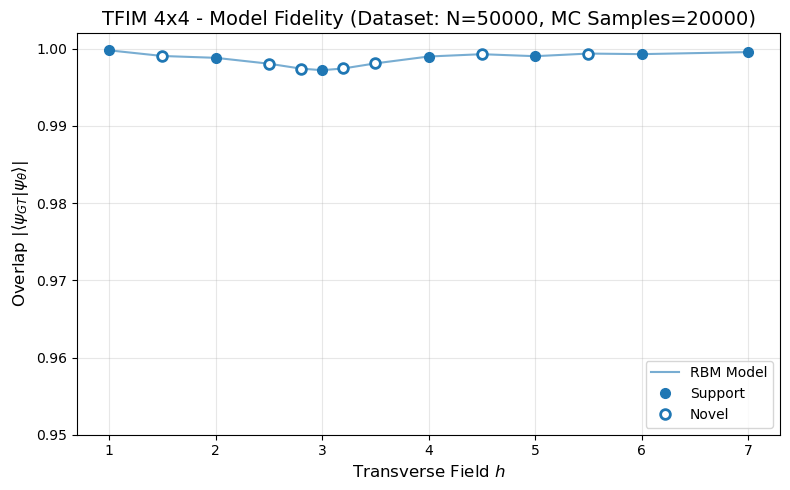

In [16]:
df = pd.DataFrame(results)
supp = df[df["type"] == "support"]
nov  = df[df["type"] == "novel"]

# Retrieve training sample count from config for title
train_samples = config.get("train_samples", "Unknown")

plt.figure(figsize=(8, 5), dpi=100)

# Line
plt.plot(df["h"], df["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")

# Support Dots
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")

# Novel Dots
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM 4x4 - Model Fidelity (Dataset: N={train_samples}, MC Samples={20000})", fontsize=14)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()